In [2]:
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import date, timedelta

In [3]:
tokens = [
    "omg","qash","gnt","snt","bat","mana","fun","zrx","rep",
    "elf","dai","ant","mkr","knc","poly","ctxc",
    "wtc","ethos","link","salt","mtl_metal","eng",
    "powr","ppt","cvc","loom","tusd","gno",
    "pay","ht","srn","veri","cennz","rhoc","drgn","usdc","kcs",
    "pax","gusd","usdt_eth","leo_eth","snx"
]

# Returns a dict of address to token balance
def get_token_ledger(asset):
    time = date.today() - timedelta(days=1)
    with psycopg2.connect("postgresql://postgres@localhost:7432/postgres-factory-staging") as conn:
        with conn.cursor() as cursor:
            cursor.execute(f"""
                SELECT
                    "account", "balance"
                FROM 
                    ledger_snapshots
                WHERE
                    asset = %s
                AND
                    time = %s
            """, (asset, time))
            
            return {acc: bal for acc, bal in cursor.fetchall()}
        
def get_owners(asset):
    return set(get_token_ledger(asset).keys())

In [4]:
# Reading all the owners of all tokens
owners = {token: get_owners(token) for token in tokens}

In [5]:
# Building a 2D map of cross-ownership
cross_ownership = []
for token in tokens:
    # How many people own this token
    token_owners = owners[token]
    n_owners = len(token_owners)
    row = [len(token_owners.intersection(owners[other])) / len(token_owners.union(owners[other])) for other in tokens]
    cross_ownership.append(row)

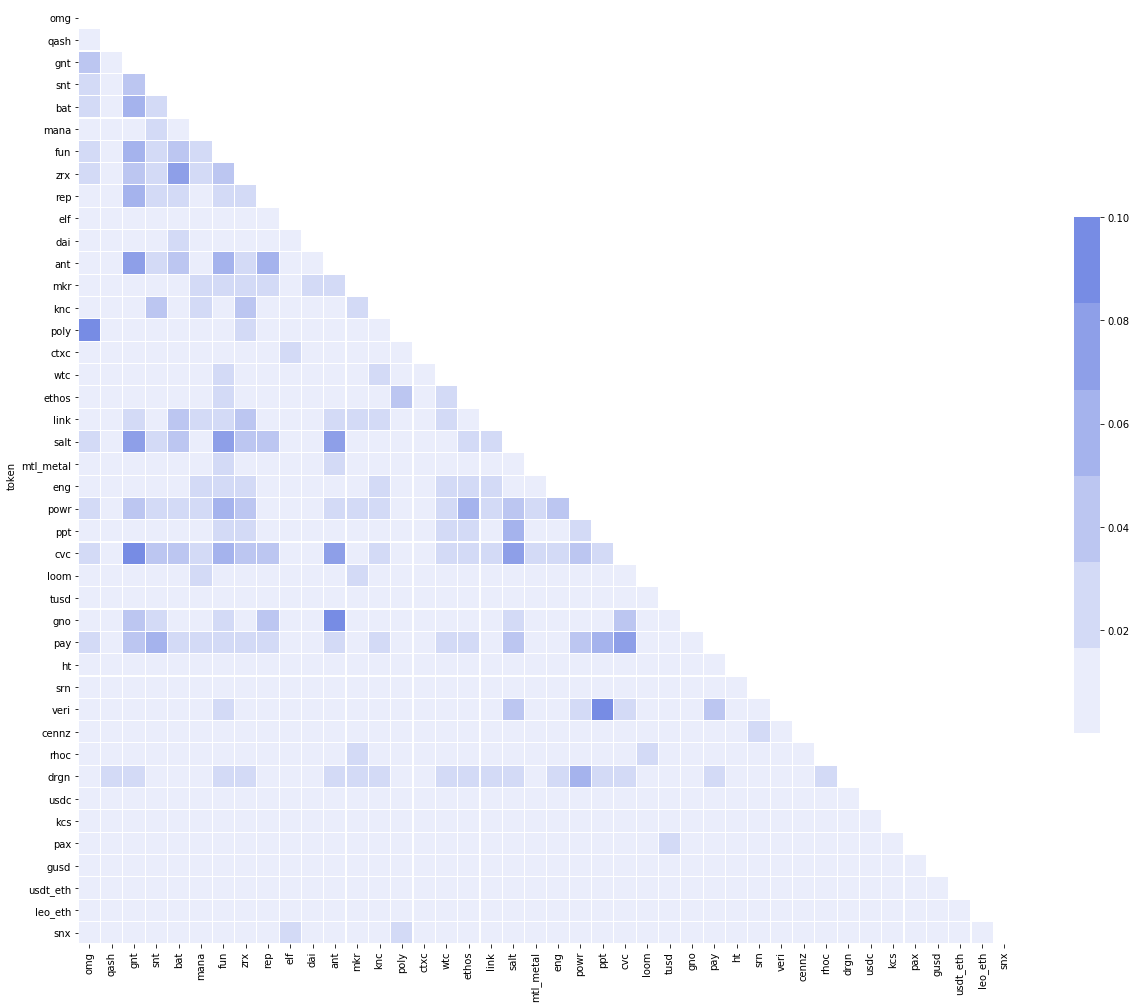

In [6]:
# Create a mask to remove the upper right half of the matrix
mask = np.zeros_like(cross_ownership, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


df = pd.DataFrame(data=cross_ownership, columns=tokens)
df["token"] = tokens
df = df.set_index("token")

f, ax = plt.subplots(figsize=(21, 19))

palette = sns.light_palette((260, 75, 60), input="husl")

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df, cmap=palette, mask=mask, vmax=0.1, square=True, linewidths=.1, cbar_kws={"shrink": .5})
# Fix cropping issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [13]:
from functools import reduce
    
all_owners = reduce(lambda x, y: set(x).union(set(y)), owners.values())
print(len(all_owners))

2459801


In [22]:
from collections import defaultdict

counts = defaultdict(int)

for owner in all_owners:
    tokens_owned = reduce(lambda x, y: x + y, [1 if owner in owners[token] else 0 for token in tokens])
    if tokens_owned > 10:
        tokens_owned = 10
    
    counts[tokens_owned] += 1
    
print(counts)    

defaultdict(<class 'int'>, {1: 2125483, 4: 24647, 2: 220710, 5: 12716, 3: 56608, 10: 3650, 6: 7125, 7: 4250, 8: 2660, 9: 1952})


In [26]:
sns.countplot(pd.DataFrame(data=counts))

ValueError: If using all scalar values, you must pass an index